In [8]:
individual_params_per_seq = False
# exp_path = f'experiments/eval_multiple_seqs/{date}'
exp_path = 'experiments/eval_multiple_seqs/2023_07_27__16_50_50'
num_seqs = 10
seq_length = 50
n_bootstrap = 10_000
n_ffbsi = 50
d_x, d_y = 10, 10
num_epochs_vi_learning = 1_000

# Preamble

## Imports

In [9]:
import argparse 
import jax, jax.numpy as jnp
import dill 
import matplotlib
from functools import partial
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
jax.config.update('jax_platform_name', 'cpu')
date = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')

from src.utils.misc import get_defaults, save_args, load_args, tree_get_slice
from src.stats.hmm import get_generative_model
from src.variational import get_variational_model
from src.training import SVITrainer
color = sns.color_palette()[1]
alpha = 0.2
matplotlib.rc('font',size=15)

## Global parameters

In [10]:
os.makedirs(exp_path, exist_ok=True)

def set_p_args(load):
  if load:
    p_args = load_args('p_args', exp_path)
  else: 
    p_args = argparse.Namespace()
    p_args.state_dim, p_args.obs_dim = 10,10
    p_args.model = 'nonlinear_emission'
    p_args.load_from = ''
    p_args.loaded_seq = False
    p_args.num_seqs = num_seqs
    p_args.seq_length = seq_length
    p_args = get_defaults(p_args)
    save_args(p_args,'p_args',exp_path)
  p_args.num_particles = n_bootstrap
  p_args.num_smooth_particles = n_ffbsi
  return p_args

def set_q_args(p_args, model, load):
  model_path = os.path.join(exp_path, model)
  if load: 
    q_args = load_args('q_args', model_path)
  else:
    os.makedirs(model_path, exist_ok=True)
    q_args = argparse.Namespace()
    q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim
    q_args.model = model
    q_args = get_defaults(q_args)
    q_args.optimizer = 'adam'
    q_args.learning_rate = 1e-2
    q_args.optim_options = 'cst'
    q_args.num_epochs = num_epochs_vi_learning
    q_args.num_samples = 2
    q_args.training_mode = f'reset,{p_args.seq_length},1'
    q_args.elbo_mode = 'autodiff_on_batch'
    q_args.logging_type = 'basic_logging'
    save_args(q_args, 'q_args', model_path)
  return q_args

## Utility functions

In [11]:
def get_sequences(key, p, theta, p_args, load):
  
  if load: 
    xs = jnp.load(os.path.join(exp_path,'xs.npy'))
    ys = jnp.load(os.path.join(exp_path,'ys.npy'))
  else: 
    xs, ys = p.sample_multiple_sequences(
                                    key, 
                                    theta, 
                                    p_args.num_seqs, 
                                    p_args.seq_length, 
                                    single_split_seq=False,
                                    load_from=p_args.load_from,
                                    loaded_seq=p_args.loaded_seq)
    jnp.save(os.path.join(exp_path,'xs.npy'), xs)
    jnp.save(os.path.join(exp_path,'ys.npy'), ys)
  return xs, ys

def get_params_q(key, p, theta, p_args, q_args, data, load):
  q = get_variational_model(q_args)

  if load:
    with open(os.path.join(exp_path, q_args.model, 'params'), 'rb') as f: 
      fitted_params = dill.load(f)
  else: 
    if individual_params_per_seq:
      num_seqs = 1
    else:
      num_seqs = len(ys)

    trainer = SVITrainer(
                    p, 
                    theta,
                    q,
                    q_args.optimizer,
                    q_args.learning_rate,
                    q_args.optim_options,
                    q_args.num_epochs, 
                    p_args.seq_length,
                    q_args.num_samples,
                    False,
                    '',
                    num_seqs,
                    q_args.training_mode,
                    q_args.elbo_mode,
                    q_args.logging_type)

    if individual_params_per_seq:
      fitted_params = []
      final_elbos = []
      for seq_nb, (x,y) in enumerate(zip(*data)):
        key, key_params, key_mc = jax.random.split(key, 3)
        data = (jnp.expand_dims(x,0), jnp.expand_dims(y,0))
        phi, final_elbo = trainer.fit(key_params, 
                                      key_mc, 
                                      data, 
                                      None,
                                      q_args,
                                      None)
        print(f'Final ELBO for sequence {seq_nb}:',final_elbo)
        fitted_params.append(phi)
        final_elbos.append(final_elbo)
    else: 
      key, key_params, key_mc = jax.random.split(key, 3)
      params, final_elbo = trainer.fit(key_params, 
                                      key_mc, 
                                      data, 
                                      None,
                                      q_args,
                                      None)
      fitted_params = [params]*p_args.num_seqs

  with open(os.path.join(exp_path, q_args.model, 'params'), 'wb') as f: 
      dill.dump(fitted_params, f)

  return q, fitted_params

def smc_path_at_multiple_timesteps(key, p, theta, timesteps, ys):
  smc_engine = p.smc
  formatted_theta = p.format_params(theta)
  paths = []

  for y in tqdm(ys): 
    key, subkey_filt = jax.random.split(key, 2)

    paths_for_y = []
    log_probs, particles = smc_engine.compute_filt_params_seq(subkey_filt, y, formatted_theta)[:-1]
    for t in timesteps:
      filt_seqs = log_probs[:t], particles[:t]
      key, subkey_smooth = jax.random.split(key, 2)
      paths_for_y.append(smc_engine.smoothing_paths_from_filt_seq(subkey_smooth,
                                                        filt_seqs,
                                                        formatted_theta))
    paths.append(paths_for_y)

  return paths
        
def get_smc_paths(key, p, theta, timesteps, ys, load):
  if load: 
    print('Loading precomputed FFBSi smoothing marginals...')
    with open(os.path.join(exp_path, 'smc_paths.dill'), 'rb') as f: 
      paths = dill.load(f)
  else:
    print('Computing FFBSi smoothing marginals...')
    paths = smc_path_at_multiple_timesteps(key, p, theta, timesteps, ys)
    with open(os.path.join(exp_path, 'smc_paths.dill'), 'wb') as f:
      dill.dump(paths, f)
  return paths

def vi_marginals_at_multiple_timesteps(q, params_q, timesteps, ys):
  vi_marginals = []
  for phi, y in tqdm(zip(params_q, ys)):
    vi_marginals_for_y = []
    for t in timesteps:
      vi_marginals_for_y.append(q.smooth_seq(y[:t], phi))
    vi_marginals.append(vi_marginals_for_y)
  return vi_marginals

def get_vi_backwd_params(q, params_q, ys):
  backwd_params_all_sequences = []
  for phi, y in tqdm(zip(params_q, ys)): 
    formatted_phi = q.format_params(phi)
    state_seq = q.compute_state_seq(y, len(y)-1, formatted_phi)
    backwd_params_seq = q.compute_backwd_params_seq(state_seq, formatted_phi)
    backwd_params_all_sequences.append(backwd_params_seq)
  return backwd_params_all_sequences

def get_vi_marginals(q, params_q, q_args, ys, timesteps, load):
  model_path = os.path.join(exp_path, q_args.model)
  if load:
    with open(os.path.join(model_path, f'vi_marginals.dill'), 'rb') as f: 
      vi_marginals = dill.load(f)
  else: 
    vi_marginals = vi_marginals_at_multiple_timesteps(q, params_q, timesteps, ys)
    with open(os.path.join(model_path, f'vi_marginals.dill'), 'wb') as f: 
      dill.dump(vi_marginals, f)
  return vi_marginals

def errors_1st_moment(smc_paths, vi_marginals, timesteps):
  
  additive_errors = {}
  marginal_errors = {}
  for exp_nb, (smc_path_all_t, vi_marginals_all_t) in enumerate(zip(smc_paths, vi_marginals)):
    additive_errors[exp_nb] = {}
    for t, smc_path_up_to_t, vi_marginals_up_to_t in zip(timesteps, smc_path_all_t, vi_marginals_all_t):
      smc_means = jnp.mean(jax.vmap(jax.vmap(partial(jnp.linalg.norm,ord=1)))(smc_path_up_to_t), axis=0)
      vi_means = jnp.linalg.norm(vi_marginals_up_to_t[0], axis=1, ord=1)
      additive_errors[exp_nb][t] = jnp.abs(jnp.sum(smc_means, axis=0) \
                                                    - jnp.sum(vi_means, axis=0)).tolist()
      marginal_errors_for_exp = jnp.abs(smc_means - vi_means)
      marginal_errors[exp_nb] = {t:v.tolist() for t,v in enumerate(marginal_errors_for_exp) if t in timesteps}

  return additive_errors, marginal_errors

def errors_2nd_moment(smc_paths, vi_marginals, timesteps):
  
  additive_errors = {}
  marginal_errors = {}
  for exp_nb, (smc_path_all_t, vi_marginals_all_t) in enumerate(zip(smc_paths, vi_marginals)):
    additive_errors[exp_nb] = {}
    for t, smc_path_up_to_t, vi_marginals_up_to_t in zip(timesteps, smc_path_all_t, vi_marginals_all_t):
      # smc_2nd_moment = jnp.mean(smc_path_up_to_t**2, axis=0)
      # vi_2nd_moment = vi_marginals_up_to_t[0]**2 + jax.vmap(jnp.diagonal)(vi_marginals_up_to_t[1])
      # additive_errors[exp_nb][t] = jnp.linalg.norm(jnp.sum(smc_2nd_moment, axis=0) \
      #                                              - jnp.sum(vi_2nd_moment, axis=0), ord=1).tolist() / p.state_dim
      smc_2nd_moment = jnp.mean(jax.vmap(jax.vmap(lambda x:x.T @ x))(smc_path_up_to_t), axis=0)
      vi_2nd_moment = jnp.sum(vi_marginals_up_to_t[0]**2 + jax.vmap(jnp.diagonal)(vi_marginals_up_to_t[1]), 
                              axis=1)
      additive_errors[exp_nb][t] = jnp.abs(jnp.sum(smc_2nd_moment, axis=0) \
                                                    - jnp.sum(vi_2nd_moment, axis=0)).tolist() 
    marginal_errors_for_exp = jnp.abs(smc_2nd_moment-vi_2nd_moment) 
    marginal_errors[exp_nb] = {t:v.tolist() for t,v in enumerate(marginal_errors_for_exp) if t in timesteps}
  return additive_errors, marginal_errors

def errors_crossprods(smc_paths, vi_marginals, vi_backwd_params, timesteps):
  
  additive_errors = {}
  marginal_errors = {}

  def analytical_crossprod(vi_1st_moment, vi_2nd_moment, vi_backwd_params):
    return vi_backwd_params.map.w @ vi_2nd_moment + vi_backwd_params.map.b * vi_1st_moment
  
  for exp_nb, (smc_path_all_t, vi_marginals_all_t, vi_backwd_params_all_t) in enumerate(zip(smc_paths, vi_marginals, vi_backwd_params)):
    additive_errors[exp_nb] = {}
    for t, smc_path_up_to_t, vi_marginals_up_to_t in zip(timesteps, smc_path_all_t, vi_marginals_all_t):
      smc_crossprods = jnp.mean(jax.vmap(jax.vmap(lambda x,y: x.T @ y))(smc_path_up_to_t[:,:-1], smc_path_up_to_t[:,1:]), axis=0)
      vi_1st_moment = vi_marginals_up_to_t[0]
      vi_2nd_moment = vi_1st_moment**2 + jax.vmap(jnp.diagonal)(vi_marginals_up_to_t[1])
      vi_backwd_params = tree_get_slice(0, t-1, vi_backwd_params_all_t)
      vi_cross_prods = jnp.sum(jax.vmap(analytical_crossprod)(vi_1st_moment[1:], vi_2nd_moment[1:], vi_backwd_params), axis=1)
      additive_errors[exp_nb][t] = jnp.abs(jnp.sum(smc_crossprods, axis=0) - jnp.sum(vi_cross_prods, axis=0)).tolist()
    marginal_errors_for_exp = jnp.abs(smc_crossprods-vi_cross_prods)
    marginal_errors[exp_nb] = {t:v.tolist() for t,v in enumerate(marginal_errors_for_exp) if t in timesteps}

  return additive_errors, marginal_errors

def plot_errors_single_model(errors, name, ax):
  errors = pd.DataFrame.from_dict(errors).unstack().reset_index()
  errors.columns = ['Sequence', 'Timesteps', name]
  sns.lineplot(errors, ax=ax, x='Timesteps', y=name, c=color)
  sns.lineplot(errors, ax=ax, x='Timesteps', y=name, style='Sequence', c=color, legend=False, alpha=alpha)

def plot_errors_all_moments(model, 
                            addititve_1st, 
                            marginal_1st, 
                            additive_2nd, 
                            marginal_2nd, 
                            additive_cross, 
                            marginal_cross):
  
  fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3,figsize=(15,10))

  plot_errors_single_model(addititve_1st, 'Additive error against FFBSi', ax0) 
  plot_errors_single_model(additive_2nd, 'Additive error against FFBSi', ax1) 
  plot_errors_single_model(additive_cross, 'Additive error against FFBSi', ax2) 

  plot_errors_single_model(marginal_1st, 'Marginal error against FFBSi', ax3) 
  plot_errors_single_model(marginal_2nd, 'Marginal error against FFBSi', ax4) 
  plot_errors_single_model(marginal_cross, 'Marginal error against FFBSi', ax5) 
  plt.tight_layout()
  plt.autoscale(True)
  plt.savefig(f'errors_on_other_moments_{model}.png')

def plot_errors_multiple_models(models, errors):
  additive_dfs = []
  marginals_dfs = []
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,10))
  plt.autoscale(True)
  plt.tight_layout()
  for model, errors_for_model in zip(models, errors):
    additive, marginals = errors_for_model
    additive_df = pd.DataFrame.from_dict(additive).unstack().reset_index()
    additive_df.columns = ['Sequence', 'Timesteps', 'Additive']
    additive_df['Model'] = model
    additive_dfs.append(additive_df)

    marginals_df = pd.DataFrame.from_dict(marginals).unstack().reset_index()
    marginals_df.columns = ['Sequence', 'Timesteps', 'Marginals']
    marginals_df['Model'] = model
    marginals_dfs.append(marginals_df)

  additive_dfs = pd.concat(additive_dfs).reset_index()

  marginals_dfs = pd.concat(marginals_dfs).reset_index()

  sns.lineplot(additive_dfs, ax=ax0, x='Timesteps', y='Additive', hue='Model')
  sns.lineplot(additive_dfs, ax=ax0, x='Timesteps', y='Additive', hue='Model', style='Sequence', legend=False, alpha=alpha)

  sns.lineplot(marginals_dfs, ax=ax1, x='Timesteps', y='Marginals', hue='Model')
  sns.lineplot(marginals_dfs, ax=ax1, x='Timesteps', y='Marginals', hue='Model', style='Sequence', legend=False, alpha=alpha)

  return additive_dfs, marginals_dfs

def get_vi_marginals_for_sequences(key, p, theta, p_args, models, data, timesteps, load):
  vi_marginals = []


  for model in models:
    print(f'Computing results for {model}')
    q_args = set_q_args(
                      p_args, 
                      model, 
                      load=load)
    
    q, params_q = get_params_q(
                              key, 
                              p,
                              theta,
                              p_args,
                              q_args, 
                              data=data, 
                              load=load)
    
    vi_marginals.append(get_vi_marginals(
                                        q, 
                                        params_q, 
                                        q_args, 
                                        ys=data[1], 
                                        timesteps=timesteps,
                                        load=load))
    print('----')

    
  return vi_marginals

# Experiment

Loading precomputed FFBSi smoothing marginals...
Computing results for johnson_backward,8_8
Num params: 380
USING AUTODIFF ON BACKWARD BATCH ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:28<00:00, 34.50it/s]
10it [01:13,  7.38s/it]


----
Computing results for conjugate_forward,8_8
Num params: 380
USING AUTODIFF ON FORWARD BATCH ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:23<00:00, 42.73it/s]
10it [01:32,  9.25s/it]


----
Computing results for neural_backward_explicit_transition,8_8
Setting up potentials from linear Gaussian ParametricKernel.
Num params: 1080
USING AUTODIFF ON BACKWARD BATCH ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:19<00:00, 51.24it/s]
10it [00:46,  4.65s/it]


----


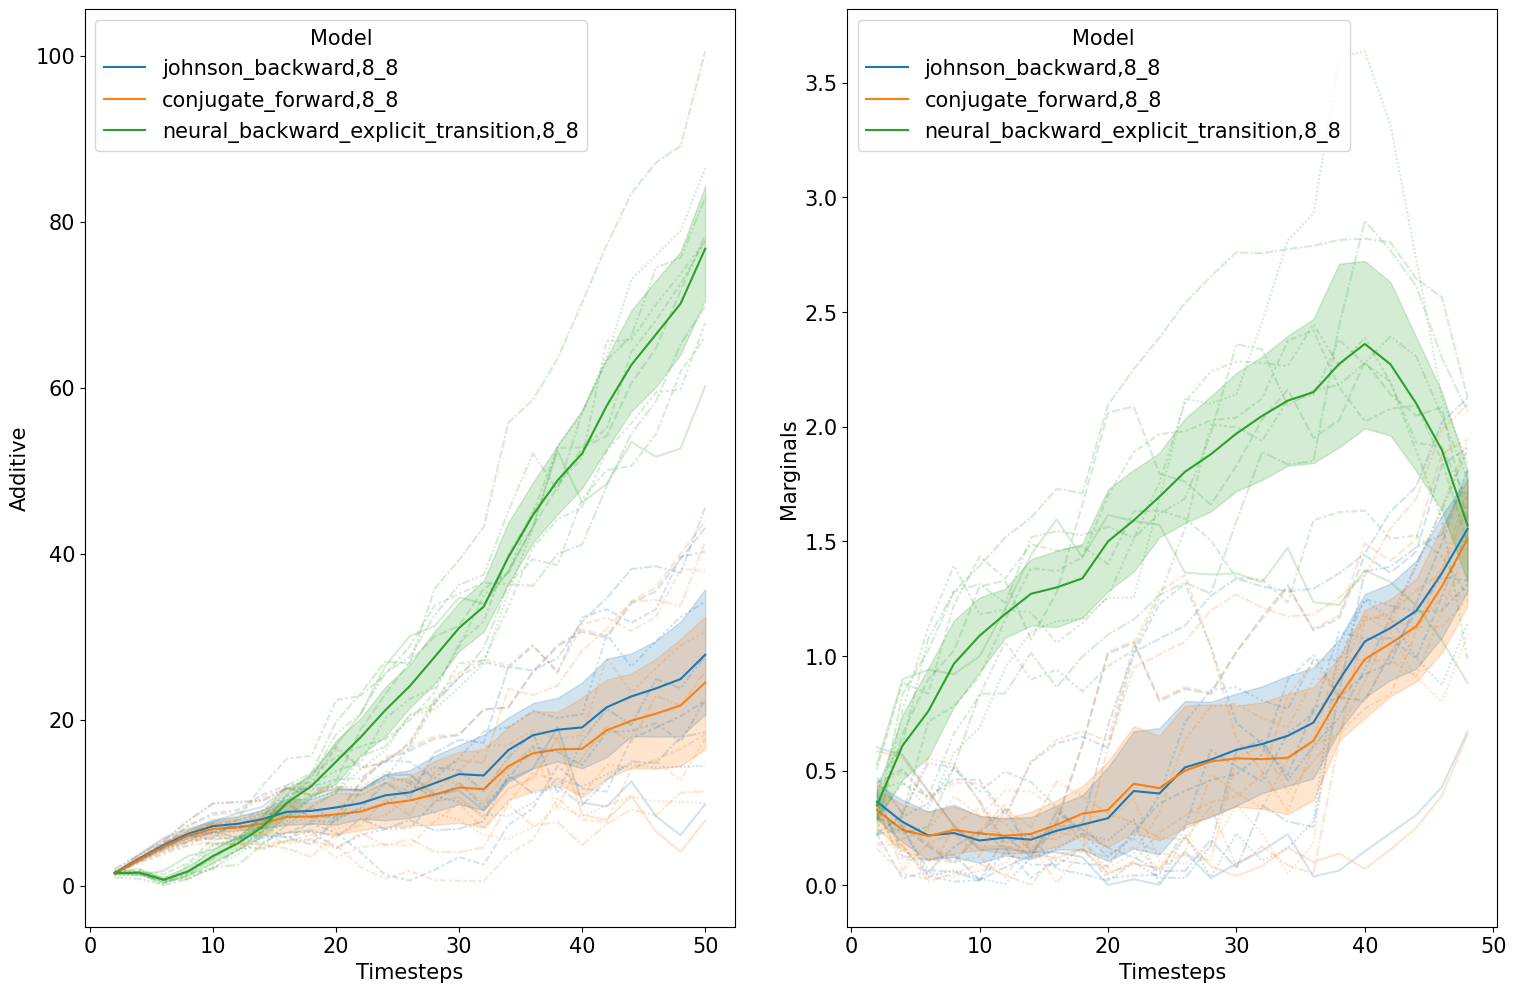

In [12]:
key = jax.random.PRNGKey(0)
models = ['johnson_backward,8_8',
          'conjugate_forward,8_8',
          'neural_backward_explicit_transition,8_8']
key_theta, key_sequences, key_smc, key_vi = jax.random.split(key, 4)
p_args = set_p_args(load=True)
num_points = 20
segment_size = p_args.seq_length // num_points

timesteps = range(segment_size , 
                  p_args.seq_length+1, 
                  segment_size)

p, theta = get_generative_model(p_args, 
                                key_theta)

xs, ys = get_sequences(key_sequences, p, theta, p_args, load=True)

smc_paths = get_smc_paths(key, p, theta, timesteps, ys, load=True)
#%%
vi_marginals = get_vi_marginals_for_sequences(key, 
                                              p,
                                              theta, 
                                              p_args,
                                              models, 
                                              data=(xs, ys), 
                                              timesteps=timesteps,
                                              load=False)


  # vi_backwd_params.append(get_vi_backwd_params(q, params_q, ys))
#%%
errors_all_models = []
for nb, model in enumerate(models):
  errors_all_models.append(errors_1st_moment(smc_paths, vi_marginals[nb], timesteps))

additive_dfs, marginals_dfs = plot_errors_multiple_models(models, errors_all_models)